# 仮説
* 購入数や閲覧数に関連があるのではないか？  
    * 商品  
    閲覧される数とカートに入れられる数にある程度の相関があったが、購入される数には相関がなかった。  
    **→購入数が少ないため、基本的に閲覧とカートを基準に閲覧の予測を行った方がよいのではないか？**・・・①
    * ユーザー  
    相関は存在しなかった。  
    →異常行動しているユーザーの存在を把握。
* ユーザー・商品をグループ分けできるのではないか？
    * 商品  
    人気商品/人気でない商品に分類することができた。  
    **→ユーザーの情報も用いてさらに分類することはできないか？**  
    **→人気商品/人気でない商品で予測を変えることができるのではないか？**
    * ユーザー  
    異常行動するユーザー/通常ユーザーに分類することができた。  
    **→異常行動ユーザー/通常ユーザーで予測を変えることができるのではないか？**
    **→異常行動ユーザーは数が比較的少ないので一人ひとり提案した方が精度があがるのではないか？**

#### 以下今回は検証できていないもの。
* ユーザーは時間とともに行動が変化するのではないか？
    * 購入後に再び閲覧・購入することはない？
    * 閲覧→カート→購入のような流れがあるのではないか？
* 買う(人気)商品の違いによって、ユーザーがグループ分けできるのではないか？ その逆もしかり。

# モデルを作る際に意識するべきこと（仮説）

## 全モデルに関して

* ユーザーのクラスターごとに人気商品を算出し、人気商品を推薦する。  
→その人気商品は全体としてみても人気？？他のクラスターではどうなのか？？一つのクラスターだけで特徴的なら、そのクラスターで推薦できる？

## 協調フィルタリングの場合

* ユーザーの行動から商品の評価値を算出する際に、購入の係数は小さい方がいいのではないか？（①より）  
→ユーザーのクラスターごとに評価値算出方法を変える？→**クラスターごとに商品の閲覧数等の相関を計算してみる。**
* 評価値の正規化

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import display
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("data/train/train_D.tsv", sep='\t')

In [3]:
dfs = []
labels = ["ca", "pd", "cl", "cv"]
for i, label in enumerate(labels):
    dic = {"id":i, "label":label, "df":df[df["event_type"] == i]}
    dfs.append(dic)

# 商品視点

In [14]:
c_dfs= []
for df_item in dfs:
    new_df = pd.DataFrame(df_item["df"].groupby("product_id").size(), columns=[df_item["label"]])
    dic = {"id":df_item["id"], "label":df_item["label"], "df":new_df}
    c_dfs.append(dic)
count_df = pd.concat([c_dfs[0]["df"],c_dfs[1]["df"],c_dfs[3]["df"]], axis=1).fillna(0)
count_df.head()

,ca,pd,cv
00000000_d,6.0,3.0,0.0
00000001_d,1.0,3.0,0.0
00000002_d,0.0,2.0,0.0
00000003_d,0.0,1.0,0.0
00000004_d,8.0,1.0,0.0


## 購入数や閲覧数に関連があるのではないか？ -商品-
* 結論  
商品が閲覧される数とカートに入る数には相関が0.7程度あったが、購入される数には全く相関がなかった。 
* 次のステップ  
結論と評価方法(評価には閲覧・(クリック)・購入が関連してくる。)、購入数の少なさを鑑みると、商品を元にしてモデルを作る際は過去の閲覧数・カートに入れられた数のみを元にして閲覧される可能性を予測する方がよいのではないか。  
↑人気商品でユーザーをグループ分けしたときに加味できそう。

### 相関行列

In [78]:
count_df.corr()

,count_0,count_1,count_3
count_0,1.000000,0.696483,0.076420
count_1,0.696483,1.000000,0.115137
count_3,0.076420,0.115137,1.000000


### 散布図

/mnt/c/home/s11te/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


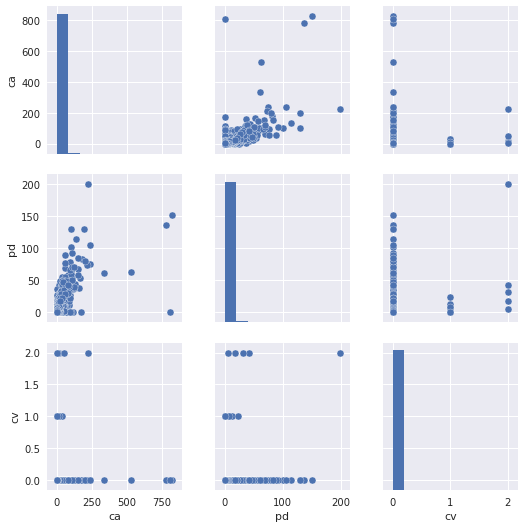

In [15]:
df_sampled = count_df.sample(n=30000, random_state=3)
sns.pairplot(df_sampled[["ca", "pd", "cv"]])
sns.plt.show()

### count_0とcount_1のクロス表

In [17]:
absense_bins = [0,50,100,150,200,250,300,350,400,500,600,700,800,900,1000,1100]
cut_result_0 = pd.cut(count_df.ca, absense_bins, right=False)

absense_bins = [0,50,100,150,200,250,300,350,400,450,500,550]
cut_result_1 = pd.cut(count_df.pd, absense_bins, right=False)

merged_count_df = pd.concat([cut_result_0, cut_result_1],axis=1)
count0_count1_cross_table = pd.pivot_table(merged_count_df, index=["ca"], columns=["pd"], aggfunc=lambda x: len(x), fill_value=0)
count0_count1_cross_table

pd,"[0, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 450)","[450, 500)","[500, 550)"
ca,,,,,,,,,,,
"[0, 50)",787853,152,2,1,2,0,1,0,1,2,0
"[50, 100)",2289,395,13,2,0,1,0,0,0,0,0
"[100, 150)",308,274,38,2,0,0,0,0,0,0,0
"[150, 200)",68,114,38,9,1,0,0,0,0,0,0
"[200, 250)",15,37,23,6,5,1,0,0,0,0,0
"[250, 300)",12,30,17,6,3,0,1,0,0,0,0
"[300, 350)",12,7,11,8,2,0,1,1,0,0,0
"[350, 400)",4,5,5,3,1,2,1,0,0,0,0
"[400, 500)",3,3,3,5,1,1,0,0,1,0,1


## 商品を閲覧された回数・カートに入れられた回数でグループ分けできないか？

* 定義  
人気がある＝閲覧数・カートに入れられた数が多いもの  
* 結論  
kmeansで4つにグループ分けすると、人気の高いもの/高くないものに分けることができたが、商品が閲覧された回数・カートに入れられた回数のみで商品を十数種類に分けることは難しい。  
* 次のステップ  
**ユーザーの情報も用いてさらに分類することはできないか？ **

### 用いるデータはcount_0(商品がカートに入れられた数),count_1(商品が閲覧された数)のみ

In [18]:
target_df = count_df.reset_index().rename(columns={"index":"product_id"})
target_df.head()

,product_id,ca,pd,cv
0,00000000_d,6.0,3.0,0.0
1,00000001_d,1.0,3.0,0.0
2,00000002_d,0.0,2.0,0.0
3,00000003_d,0.0,1.0,0.0
4,00000004_d,8.0,1.0,0.0


### エルボー法を用いて、cluster数を4にすることとする。

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(target_df[["ca", "pd"]])
target_df_std = sc.transform(target_df[["ca", "pd"]])

In [212]:
from sklearn.cluster import KMeans
X = target_df_std
dist_list =[]
for i in range(1,20):
    kmpp = KMeans(n_clusters=i,init="random",n_init=5,max_iter=100,random_state=0) 
    kmpp.fit(X)
    dist_list.append(kmpp.inertia_)

/mnt/c/home/s11te/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


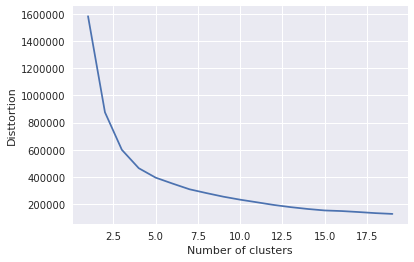

In [213]:
plt.plot(range(1,20),dist_list,marker='+')
plt.xlabel("Number of clusters")
plt.ylabel("Disttortion")

In [11]:
from sklearn.cluster import KMeans
X = target_df_std
kmpp = KMeans(n_clusters=4,init="random",random_state=0)
kmpp.fit(X)
label_df = pd.DataFrame(kmpp.labels_, columns=["cluster"])

### クラスターごとの特徴

* cluster0  
１番人気がない領域。閲覧数もカートに入れられた数もほとんど0-5以下。  
* cluster1  
２番目に人気がない領域。閲覧数は0-30,カートに入れられた数は10-40ほど。
* cluster2  
１番人気の領域。閲覧数は40-200,カートに入れられた数は130-400ほど。閲覧数0なのにカートに入れられた数800のような極端な例も存在する。
* cluster3  
２番人気の領域。閲覧数は20-60,カートに入れられた数は30-110ほど。

In [12]:
label_df.groupby("cluster").size()

cluster
0    761774
1     26502
2       353
3      3193
dtype: int64

In [13]:
# clustered_df = pd.concat([target_df, label_df], axis=1)
# clustered_df.to_csv("data/train/clustered_product_without_cv_D.csv",index=False)
clustered_df = pd.read_csv("data/train/clustered_product_without_cv_D.csv")

In [9]:
absense_bins = [0,10,20,30,40,50,100,150,200,250,300,350,400,500,1100]
cut_result = pd.cut(clustered_df.count_0, absense_bins, right=False)
merged_clusterd_df = pd.concat([clustered_df.cluster, cut_result], axis=1)
cluster_count_0_cross_table = pd.pivot_table(merged_clusterd_df, index=["cluster"], columns=["ca"],aggfunc=lambda x : len(x), fill_value = 0)
display(cluster_count_0_cross_table)

absense_bins = [0,10,20,30,40,50,100,150,200,250,300,350,400,450,500,550]
cut_result = pd.cut(clustered_df.count_1, absense_bins, right=False)
merged_clusterd_df = pd.concat([clustered_df.cluster, cut_result], axis=1)
cluster_count_1_cross_table = pd.pivot_table(merged_clusterd_df, index=["cluster"], columns=["pd"],aggfunc=lambda x : len(x), fill_value = 0)
display(cluster_count_1_cross_table)

count_0,"[0, 10)","[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 500)","[500, 1100)"
cluster,,,,,,,,,,,,,,
0,742857,18177,740,0,0,0,0,0,0,0,0,0,0,0
1,3703,10639,6625,3100,1366,1042,27,0,0,0,0,0,0,0
2,2,1,0,1,2,3,26,83,73,62,42,21,18,19
3,11,16,89,243,442,1655,569,147,14,7,0,0,0,0


count_1,"[0, 10)","[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 450)","[450, 500)","[500, 550)"
cluster,,,,,,,,,,,,,,,
0,761514,260,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13018,10585,2487,403,9,0,0,0,0,0,0,0,0,0,0
2,28,0,1,1,5,120,125,42,16,5,4,1,2,2,1
3,98,57,444,952,712,899,29,2,0,0,0,0,0,0,0


In [54]:
for i in range(0,4):
    display_df = pd.DataFrame()
    display_target_df = clustered_df[clustered_df["cluster"] == i][["ca", "pd"]]
    if display_df.empty:
        display_df = display_target_df.describe().T
    else:
        display_df = pd.concat([display_df, display_target_df.describe().T])
    display(display_df)
    print("cluster_" + str(i))

,count,mean,std,min,25%,50%,75%,max
count_0,761774.0,2.119896,2.547145,0.0,1.0,1.0,3.0,23.0
count_1,761774.0,0.772136,1.275835,0.0,0.0,0.0,1.0,11.0


cluster_0


,count,mean,std,min,25%,50%,75%,max
count_0,26502.0,21.448608,13.426281,0.0,12.0,18.0,27.0,111.0
count_1,26502.0,10.698777,6.817840,0.0,6.0,10.0,14.0,44.0


cluster_1


,count,mean,std,min,25%,50%,75%,max
count_0,353.0,266.144476,134.252239,2.0,183.0,239.0,313.0,1015.0
count_1,353.0,115.507082,72.828531,0.0,80.0,106.0,140.0,516.0


cluster_2


,count,mean,std,min,25%,50%,75%,max
count_0,3193.0,76.764485,37.960708,0.0,49.0,68.0,96.0,291.0
count_1,3193.0,42.963984,18.386982,0.0,32.0,40.0,52.0,156.0


cluster_3


/mnt/c/home/s11te/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


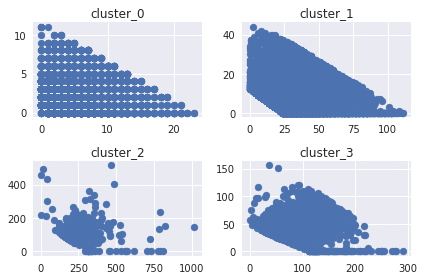

In [47]:
for i in range(0,4):
    if i == 0:
        df_sampled = clustered_df[clustered_df["cluster"] == i].sample(n=30000, random_state=3)
    else:
        df_sampled = clustered_df[clustered_df["cluster"] == i]
    plt.subplot(2, 2, i+1)
    plt.scatter(df_sampled["ca"],df_sampled["pd"])
    plt.title("cluster_" + str(i))
plt.tight_layout() 

# ユーザー視点

In [19]:
c_dfs= []
for df_item in dfs:
    new_df = pd.DataFrame(df_item["df"].groupby("user_id").size(), columns=[df_item["label"]])
    dic = {"id":df_item["id"], "label":df_item["label"], "df":new_df}
    c_dfs.append(dic)
count_df = pd.concat([c_dfs[0]["df"],c_dfs[1]["df"],c_dfs[3]["df"]], axis=1).fillna(0)
count_df.head()

,ca,pd,cv
0000000_D,23.0,5.0,0.0
0000001_D,32.0,18.0,0.0
0000002_D,4.0,6.0,0.0
0000003_D,54.0,43.0,0.0
0000004_D,4.0,8.0,0.0


## 購入数や閲覧数に関連があるのではないか？ -ユーザー-

* 結論  
ユーザーの購入数・閲覧数・カートに入れる数に相関は全くなかった。  

全く閲覧も購入もせずにカートに入れまくったりとする異常な行動をするユーザーがかなり存在していた。  
→そのような異常なユーザーを簡易的に取り除いてみても相関はなかった。また、閲覧数カートに入れる数が50以下のみにしぼっても相関は見られなかった。

### 相関行列

In [20]:
display(count_df.corr())
display(count_df.loc[~(count_df["ca"]>350) & (count_df["pd"]<50)].corr())
display(count_df.loc[(count_df["ca"]<50) & (count_df["pd"]<50)].corr())

,ca,pd,cv
ca,1.000000,0.075971,0.008084
pd,0.075971,1.000000,0.101088
cv,0.008084,0.101088,1.000000


,ca,pd,cv
ca,1.000000,0.110025,0.014476
pd,0.110025,1.000000,0.014763
cv,0.014476,0.014763,1.000000


,ca,pd,cv
ca,1.000000,-0.041789,-0.000705
pd,-0.041789,1.000000,0.014661
cv,-0.000705,0.014661,1.000000


### 散布図

/mnt/c/home/s11te/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


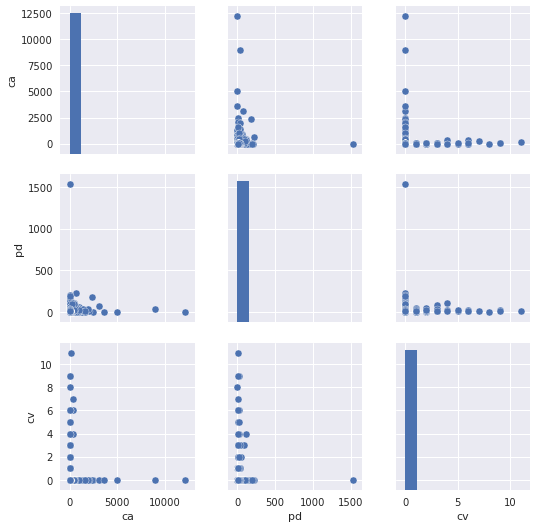

In [21]:
df_sampled = count_df.sample(n=30000, random_state=3)
sns.pairplot(df_sampled[["ca", "pd", "cv"]])
sns.plt.show()

In [22]:
absense_bins = [0,10,20,30,40,50,100,150,200,250,300,350,400,500,600,700,800,900,1000,15000]
cut_result_0 = pd.cut(count_df.ca, absense_bins, right=False)

absense_bins = [0,10,20,30,40,50,100,150,200,250,300,1600]
cut_result_1 = pd.cut(count_df.pd, absense_bins, right=False)

merged_count_df = pd.concat([cut_result_0, cut_result_1],axis=1)
count0_count1_cross_table = pd.pivot_table(merged_count_df, index=["ca"], columns=["pd"], aggfunc=lambda x: len(x), fill_value=0)
count0_count1_cross_table

pd,"[0, 10)","[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[300, 1600)"
ca,,,,,,,,,,
"[0, 10)",22568,16594,1760,365,116,78,11,3,1,1
"[10, 20)",25048,7543,1230,235,58,27,2,0,1,0
"[20, 30)",8991,3733,899,219,60,40,0,0,0,0
"[30, 40)",3552,2082,634,178,53,31,3,0,0,0
"[40, 50)",1852,1077,440,173,51,30,0,1,0,0
"[50, 100)",2833,1608,927,410,198,131,9,1,1,0
"[100, 150)",594,297,175,128,72,88,2,0,0,0
"[150, 200)",238,84,61,53,29,38,2,0,0,1
"[200, 250)",125,47,36,23,19,31,3,0,0,0


## ユーザーをグループ分けできないか？

* 結論  
kmeansで11つにグループ分けすると、全く閲覧も購入もせずにカートに入れまくったりとする異常な行動をするユーザーをある程度グループとして抽出することができた。  
* 次のステップ  
**異常行動をするユーザーとそれ以外に分けて、予測に用いる。**

### 用いるデータはcount_0,1,3すべて

In [23]:
target_df = count_df.reset_index().rename(columns={"index":"user_id"})
target_df.head()

,user_id,ca,pd,cv
0,0000000_D,23.0,5.0,0.0
1,0000001_D,32.0,18.0,0.0
2,0000002_D,4.0,6.0,0.0
3,0000003_D,54.0,43.0,0.0
4,0000004_D,4.0,8.0,0.0


### エルボー法を用いて、cluster数を11にすることとする。

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(target_df[["ca", "pd", "cv"]])
target_df_std = sc.transform(target_df[["ca", "pd", "cv"]])

In [98]:
from sklearn.cluster import KMeans
X = target_df_std
dist_list =[]
for i in range(1,20):
    kmpp = KMeans(n_clusters=i,init="random",n_init=5,max_iter=100,random_state=0) 
    kmpp.fit(X)
    dist_list.append(kmpp.inertia_)

/mnt/c/home/s11te/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


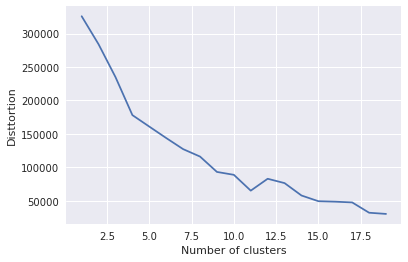

In [99]:
plt.plot(range(1,20),dist_list,marker='+')
plt.xlabel("Number of clusters")
plt.ylabel("Disttortion")

In [35]:
from sklearn.cluster import KMeans
X = target_df_std
kmpp = KMeans(n_clusters=11,init="random",random_state=0)
kmpp.fit(X)
label_df = pd.DataFrame(kmpp.labels_, columns=["cluster"])

### クラスターごとの特徴

0:cartが異常に多くpdが少ない  
1:cartが多くpdが少ない  
2:cartが非常に多くpdが少ない  
3:cartもpdも多め  
4:cartもpdも少ない  
5:cartもpdも少ないが若干cartが多い  
6:pdが異常に多くcartが少ない  
7:ともに普通  
8:ともに普通  
9:cartがけっこう多くpdが少ない  
10:ともに少し多め  

In [18]:
label_df.groupby("cluster").size()

cluster
0         5
1        23
2        28
3       407
4     48230
5     34592
6         2
7       358
8     20225
9       306
10     4431
dtype: int64

In [36]:
# clustered_df = pd.concat([target_df, label_df], axis=1)
# clustered_df.to_csv("data/train/clustered_user_D.csv",index=False)
clustered_df = pd.read_csv("data/train/clustered_user_D.csv"")

In [21]:
absense_bins = [0,50,100,150,200,250,300,350,400,500,1100,15000]
cut_result = pd.cut(clustered_df.count_0, absense_bins, right=False)
merged_clusterd_df = pd.concat([clustered_df.cluster, cut_result], axis=1)
cluster_count_0_cross_table = pd.pivot_table(merged_clusterd_df, index=["cluster"], columns=["ca"],aggfunc=lambda x : len(x), fill_value = 0)
display(cluster_count_0_cross_table)

absense_bins = [0,50,100,150,200,250,300,1600]
cut_result = pd.cut(clustered_df.count_1, absense_bins, right=False)
merged_clusterd_df = pd.concat([clustered_df.cluster, cut_result], axis=1)
cluster_count_1_cross_table = pd.pivot_table(merged_clusterd_df, index=["cluster"], columns=["pd"],aggfunc=lambda x : len(x), fill_value = 0)
display(cluster_count_1_cross_table)

count_0,"[0, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 500)","[500, 1100)","[1100, 15000)"
cluster,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,5
1,16,2,1,1,0,0,3,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,28
3,137,85,59,30,29,19,15,7,15,10,1
4,47079,1019,120,12,0,0,0,0,0,0,0
5,31274,2306,545,234,131,76,26,0,0,0,0
6,1,0,0,1,0,0,0,0,0,0,0
7,315,32,4,3,0,0,1,0,1,2,0
8,18114,1639,302,87,52,23,8,0,0,0,0


count_1,"[0, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[300, 1600)"
cluster,,,,,,
0,4,1,0,0,0,0
1,21,2,0,0,0,0
2,24,3,0,1,0,0
3,0,352,41,8,5,1
4,48230,0,0,0,0,0
5,34592,0,0,0,0,0
6,0,0,0,0,0,2
7,349,8,1,0,0,0
8,20225,0,0,0,0,0


In [126]:
for i in range(0,11):
    display_df = pd.DataFrame()
    display_target_df = clustered_df[clustered_df["cluster"] == i][["ca", "pd"]]
    if display_df.empty:
        display_df = display_target_df.describe().T
    else:
        display_df = pd.concat([display_df, display_target_df.describe().T])
    display(display_df)
    print("cluster_" + str(i))

,count,mean,std,min,25%,50%,75%,max
count_0,5.0,10538.2,2855.797209,7887.0,8934.0,8944.0,12165.0,14761.0
count_1,5.0,19.4,23.828554,0.0,0.0,9.0,34.0,54.0


cluster_0


,count,mean,std,min,25%,50%,75%,max
count_0,23.0,70.260870,106.974176,1.0,8.5,16.0,66.5,341.0
count_1,23.0,15.304348,15.516662,0.0,7.5,11.0,19.0,61.0


cluster_1


,count,mean,std,min,25%,50%,75%,max
count_0,28.0,3191.035714,1139.957552,1923.0,2467.5,2695.0,3629.25,5956.0
count_1,28.0,23.428571,39.226246,0.0,0.0,10.0,21.75,180.0


cluster_2


,count,mean,std,min,25%,50%,75%,max
count_0,407.0,132.950860,146.277917,0.0,33.5,86.0,188.0,1362.0
count_1,407.0,77.248157,30.675159,51.0,60.5,66.0,81.0,300.0


cluster_3


,count,mean,std,min,25%,50%,75%,max
count_0,48230.0,12.390110,13.410728,0.0,4.0,9.0,16.0,180.0
count_1,48230.0,8.677006,1.902790,6.0,7.0,9.0,10.0,12.0


cluster_4


,count,mean,std,min,25%,50%,75%,max
count_0,34592.0,25.092507,30.217198,5.0,11.0,16.0,26.0,334.0
count_1,34592.0,2.935419,1.856552,0.0,1.0,3.0,5.0,10.0


cluster_5


,count,mean,std,min,25%,50%,75%,max
count_0,2.0,97.0,134.350288,2.0,49.5,97.0,144.5,192.0
count_1,2.0,1337.0,272.943218,1144.0,1240.5,1337.0,1433.5,1530.0


cluster_6


,count,mean,std,min,25%,50%,75%,max
count_0,358.0,26.139665,67.134486,0.0,5.0,12.0,22.75,968.0
count_1,358.0,13.952514,12.694668,0.0,7.0,10.0,17.00,107.0


cluster_7


,count,mean,std,min,25%,50%,75%,max
count_0,20225.0,21.566082,28.768058,0.0,4.0,13.0,28.0,314.0
count_1,20225.0,16.706897,3.322378,11.0,14.0,16.0,19.0,25.0


cluster_8


,count,mean,std,min,25%,50%,75%,max
count_0,306.0,615.303922,297.257799,323.0,403.75,505.0,707.75,1820.0
count_1,306.0,14.124183,16.662442,0.0,1.00,7.0,23.00,84.0


cluster_9


,count,mean,std,min,25%,50%,75%,max
count_0,4431.0,50.783119,54.278266,0.0,14.0,36.0,68.0,383.0
count_1,4431.0,33.225683,7.239101,21.0,28.0,31.0,37.0,56.0


cluster_10


/mnt/c/home/s11te/.anyenv/envs/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


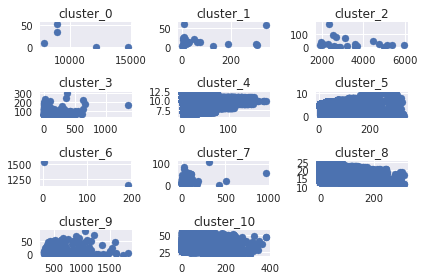

In [125]:
for i in range(0,11):
    df_sampled = clustered_df[clustered_df["cluster"] == i]
    plt.subplot(4,3, i+1)
    plt.scatter(df_sampled["ca"],df_sampled["pd"])
    plt.title("cluster_" + str(i))
plt.tight_layout() 